# Load simulated data

In [78]:
import numpy as np
import torch

from teddy.data.Alphabet import Alphabet
from teddy.data.dataset import *
import numpy as np
import pandas as pd

alphabet = Alphabet(["A", "C", "G", "T"])
sims = MsaLabels("data/example/seq", alphabet)

theta, x = [], []

theta_0 = torch.Tensor(sims[0][1])
x_0 = torch.flatten(torch.Tensor(sims[0][0][0]))

design_params = pd.read_csv("data/example/design.csv", sep=';', index_col="output_file").sort_index().reset_index()

In [79]:
param_labels = ["birth_rate", "death_rate", "sampling_proportion", "clock_rate"]
for k, sim in enumerate(sims):
    theta_k = design_params.iloc[k][param_labels].values.tolist()
    if k == 0:
        theta_0 = torch.Tensor(theta_k)
        continue
    x.append(sim[0][0])
    theta.append(theta_k)

theta = torch.Tensor(np.array(theta))
x = torch.flatten(torch.Tensor(np.array(x)), start_dim=1)

print(theta.shape, x.shape, x_0.shape)


torch.Size([999, 4]) torch.Size([999, 151702]) torch.Size([151702])


In [80]:
theta_0

tensor([0.1030, 0.1013, 0.0329, 0.0002])

# NPE training

In [81]:
from sbi.inference import NPE

npe = NPE()
npe.append_simulations(theta, x)
npe.train()

 Neural network successfully converged after 38 epochs.

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
            (context_layer): Linear(in_features=151702, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=8, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
            (context_layer): Linear(in_fe

In [70]:
from sbi.inference import NLE

# nle = NLE()
# nle.append_simulations(theta, x)
# nle.train()

In [82]:
posterior = npe.build_posterior()
samples = posterior.sample((1_000,), x=x_0)

100%|██████████| 1000/1000 [00:01<00:00, 528.03it/s]


In [83]:
param_labels

['birth_rate', 'death_rate', 'sampling_proportion', 'clock_rate']

In [84]:
theta_0

tensor([0.1030, 0.1013, 0.0329, 0.0002])

/tmp/ipykernel_453634/2526151812.py:5: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


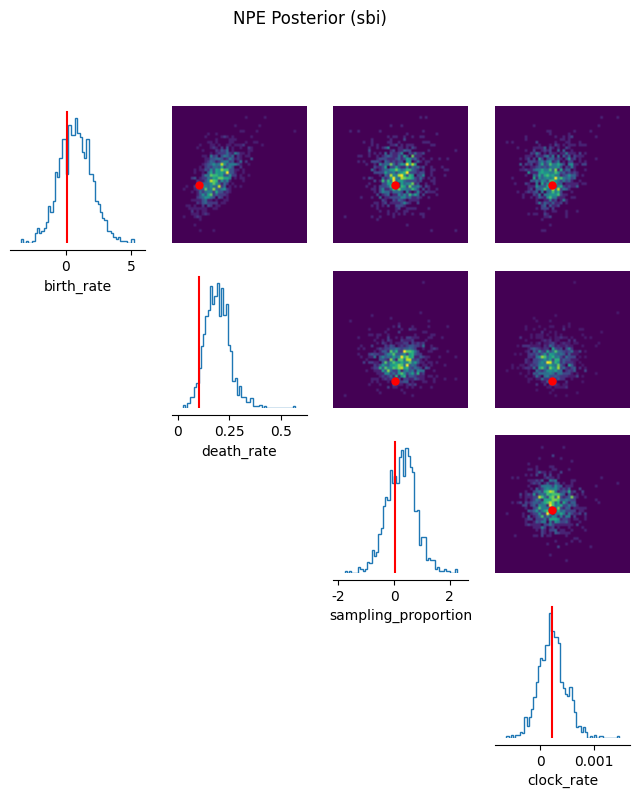

In [85]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot


fig, axes = pairplot(
    samples,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,  # True parameters
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()